# training_data_kok14_galfa with learnable positional embedding (Adding)

## Package Installation

In [1]:
import os
import sys

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\HI2\HI


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Libraries

In [4]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [5]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))
# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

## Split train, validation and testing set from X_train and Y_train. (60%, 20%, 20%)

In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [7]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

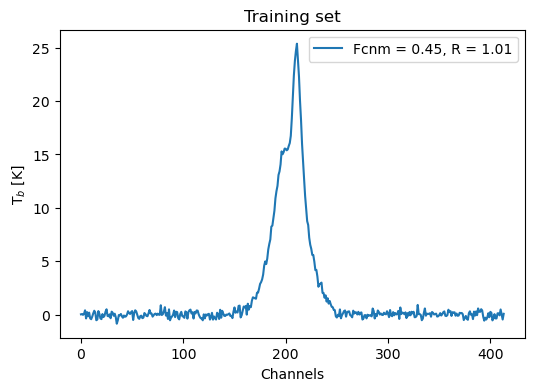

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

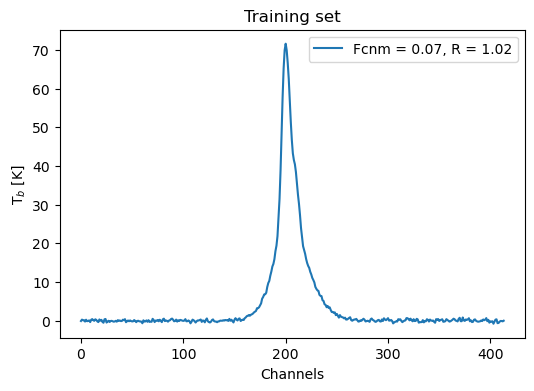

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Data loader

In [10]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        
        zero = np.linspace(0, 1.0, 414).reshape(1, -1)
        spectra = self.x[idx,:]
        #two = zero + spectra**2
        #result = np.vstack((zero,spectra,two))
        #print(result.shape)
        label = self.y[idx,:]
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.reshape(1, spectra.shape[0])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [11]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [12]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [13]:
# initialize dataset
dataset_train = HI_dataset(x_train, y_train,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_val = HI_dataset(x_val, y_val,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(X_test, Y_test,transform=ToTensor_x(), target_transform=ToTensor_y())

In [14]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [15]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 414])
torch.Size([20, 2])


## CNN Model

In [16]:
import math
class Net_origin_deep(nn.Module):
    def __init__(self, num_output=2, in_channels=1, num_output_1=72, num_output_2=64, num_output_3=56, num_output_4=48):
        super(Net_origin_deep, self).__init__()
        # layers
        self.pos_embedding = nn.Parameter(torch.randn(1, 414))
        #self.pos_embedding = nn.Parameter((1, 414))
        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels=num_output_1, kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn1 = nn.BatchNorm1d(num_output_1)
        self.conv2 = nn.Conv1d(in_channels= num_output_1, out_channels=num_output_2, kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn2 = nn.BatchNorm1d(num_output_2)
            
        self.conv3 = nn.Conv1d(in_channels = num_output_2, out_channels=num_output_3, kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn3 = nn.BatchNorm1d(num_output_3)
        self.conv4 = nn.Conv1d(in_channels= num_output_3, out_channels=num_output_4, kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn4 = nn.BatchNorm1d(num_output_4)
        
        self.conv5 = nn.Conv1d(in_channels = num_output_4, out_channels=40, kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn5 = nn.BatchNorm1d(40)
        self.conv6 = nn.Conv1d(in_channels= 40, out_channels=32, kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn6 = nn.BatchNorm1d(32)
        
        self.conv7 = nn.Conv1d(in_channels = 32, out_channels=16, kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn7 = nn.BatchNorm1d(16)
        self.conv8 = nn.Conv1d(in_channels= 16, out_channels=8, kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn8 = nn.BatchNorm1d(8)
        
        self.dropout0 = nn.Dropout(0.20)
        self.dropout = nn.Dropout(0.30)

        self.linear = nn.Linear(1904, num_output)
        self.flatten = nn.Flatten()

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        #print(1, x.size())
        x = x + self.pos_embedding
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #x = self.dropout0(x)
        #print(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout0(x)
        #print(3, x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #x = self.dropout0(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout0(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.dropout0(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        #
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        #print(4, x.size())
        return x

## Loss and Optimization

In [17]:
# training setting
lr = 0.005
#lr = 0.0005
num_epoch = 80
num_step = x_train.shape[0]/batch_size
loss_function = nn.MSELoss()
model =  Net_origin_deep()
best_err = 100000
optimizer = torch.optim.SGD(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones = [65], gamma=0.1, last_epoch=-1, verbose=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
model.to(device)

Net_origin_deep(
  (conv1): Conv1d(1, 72, kernel_size=(6,), stride=(1,))
  (bn1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(72, 64, kernel_size=(40,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 56, kernel_size=(6,), stride=(1,))
  (bn3): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(56, 48, kernel_size=(40,), stride=(1,))
  (bn4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(48, 40, kernel_size=(6,), stride=(1,))
  (bn5): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(40, 32, kernel_size=(40,), stride=(1,))
  (bn6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(32, 16, kernel_size=(6,), stride=(1,))
  (bn7): BatchNorm1d(16, eps=1e-05, momentum=0.1

In [18]:
# number of parameter
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return total_params
print("number of parameter:", count_parameters(model))

number of parameter: 389920


## Model Training and Evaluation 

In [19]:
training_MES = []
vaidation_MSE = []
testing_MSE = []

In [20]:
# train 
def train(epoch):
    model.train()
    global training_MES
    print('\nEpoch: %d' % epoch)
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward 
        outputs = model(inputs)
        #print("output = ", outputs)
        loss = loss_function(outputs, values)
        #print("loss = ", loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
        if (index+1)%500==0:
            print(f'epoch: {epoch+1}/{num_epoch}, step: {index+1}/{num_step}, avg_loss = {train_loss/total}')
            #print(f'truth = {values}, preditction = {outputs}, error = {loss.item()}')
            #print("outputs = ", outputs)
            #print(model.conv1.weight.grad) 
    training_MES.append(train_loss/total)
    print("total loss = ", train_loss)
    print("total = ",total)

In [24]:
def validation(epoch):
    model.eval()
    global best_err
    global vaidation_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float() 
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    vaidation_MSE.append(test_loss/total)
    # Save checkpoint.
    error =  test_loss / total
    print('avg_validate_accuracy=', error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/Learnable_PE_Adding.pth')
        best_err = error

In [25]:
def test(epoch):
    model.eval()
    global best_err
    global testing_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        testing_MSE.append(test_loss/total)
        print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')

## Start Training

In [26]:
# start training
for epoch in range(num_epoch):
    train(epoch)
    validation(epoch)
    scheduler.step()
    test(epoch)


Epoch: 0
epoch: 1/80, step: 500/1163.4, avg_loss = 0.036331693205982445
epoch: 1/80, step: 1000/1163.4, avg_loss = 0.030452885657548903
total loss =  680.7208223938942
total =  23268
avg_validate_accuracy= 0.009836657611339086
best_err: 0.009836657611339086 Saving..
Test performance in epoch 0: avg_error = 0.015453737550254526

Epoch: 1
epoch: 2/80, step: 500/1163.4, avg_loss = 0.020458938892930746
epoch: 2/80, step: 1000/1163.4, avg_loss = 0.01950850724428892
total loss =  447.4912792313844
total =  23268
avg_validate_accuracy= 0.009729477617017398
best_err: 0.009729477617017398 Saving..
Test performance in epoch 1: avg_error = 0.015060186482452113

Epoch: 2
epoch: 3/80, step: 500/1163.4, avg_loss = 0.016577997184358536
epoch: 3/80, step: 1000/1163.4, avg_loss = 0.01574485471053049
total loss =  361.520888841711
total =  23268
avg_validate_accuracy= 0.010279903841510419
Test performance in epoch 2: avg_error = 0.016087228464412278

Epoch: 3
epoch: 4/80, step: 500/1163.4, avg_loss = 0

## plot traing process

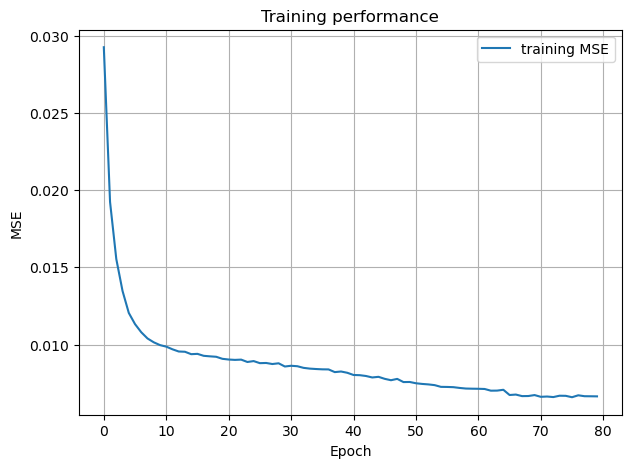

In [27]:
x = training_MES
plt.figure(figsize=(7,5))
plt.title('Training performance')
plt.plot(x, label='training MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\no_positional_info_training.jpg")
plt.show()

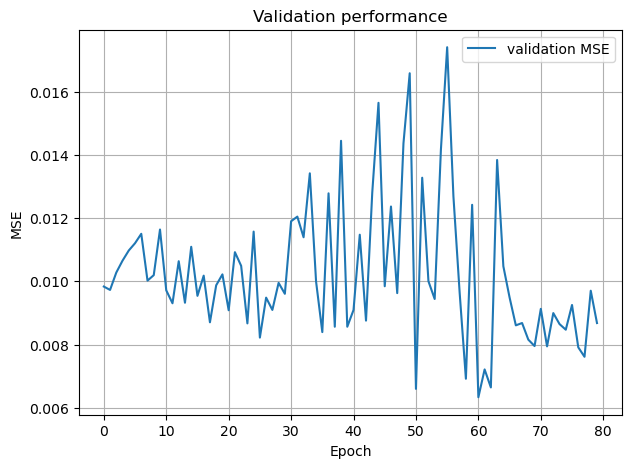

In [28]:
x = vaidation_MSE
plt.figure(figsize=(7,5))
plt.title('Validation performance')
plt.plot(x, label='validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\no_positional_info_validation.jpg")
plt.show()

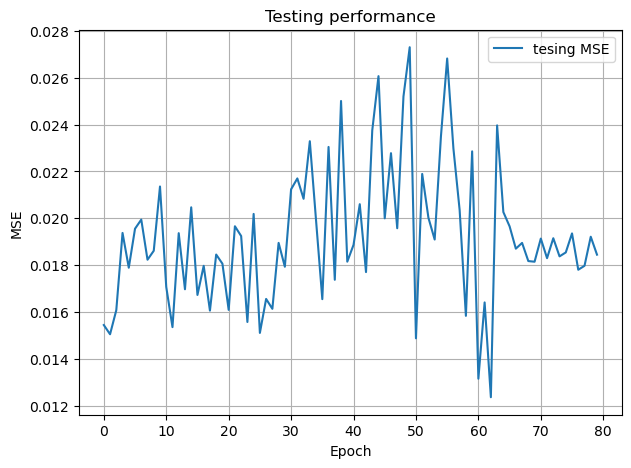

In [29]:
x = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Testing performance')
plt.plot(x, label='tesing MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\no_positional_info_testing.jpg")
plt.show()

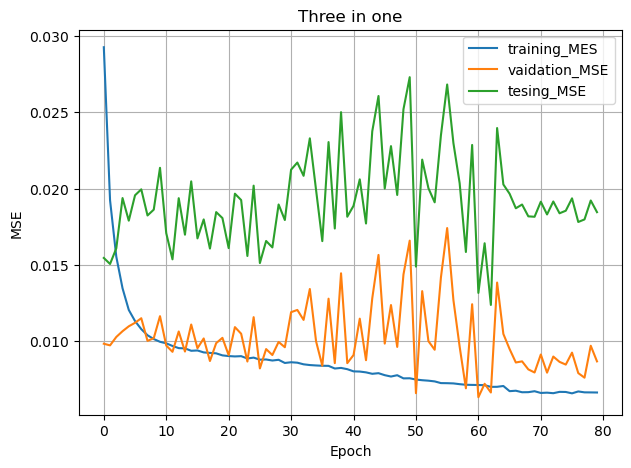

In [30]:
x1 = training_MES
x2 = vaidation_MSE
x3 = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Three in one')
plt.plot(x1, label='training_MES')
plt.plot(x2, label='vaidation_MSE')
plt.plot(x3, label='tesing_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\Learnable_PE_Adding.jpg")
plt.show()

## Save into excel

In [31]:
x1 = np.array(training_MES).reshape(1, -1)
x2 = np.array(vaidation_MSE).reshape(1, -1)
x3 = np.array(testing_MSE).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_excel(excel_writer = os.path.join(os.getcwd(),"training_process") + "\\Learnable_PE_adding.xlsx")

## Model Testing

In [32]:
# model testing

model =  Net_origin_deep()
checkpoint = torch.load('./checkpoint/Learnable_PE_Adding.pth')
model.load_state_dict(checkpoint['net'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']
test(epoch)

Test performance in epoch 60: avg_error = 0.013165622612397218
